In [148]:
from src.dataloader import *
from src.confusion_matrix import make_confusion_matrix
from src.lenet5 import buildModel


from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
import tensorflow as tf
import keras
import keras.layers as layers
from keras.losses import BinaryCrossentropy


# LeNet5: implémentation et apprentissage

## Absence de data augmentations

Le LeNET5 a été conçu pour prendre en entrée des images de dimension 28*28. On passe donc les images 400 x 400 en 28 x 28. On convertit ensuite ces dernières en tenseurs. On entraîne le LeNet5 sans data augmentations. Nous fixons les hyper-paramètres de façon arbitraire dans un premier temps:
* Learning rate: 0,01
* Momentum: 0,9
* Dropout: 0,2
* epochs: 10
* batch size: 32

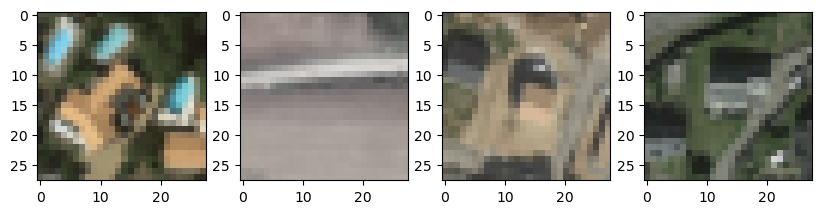

In [149]:
path_train = "C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/train_data.csv"
path_test = "C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/test_data.csv"

transformed_train_dataset = CustomImageDataset(path_train, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
]))
transformed_test_dataset = CustomImageDataset(path_test, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                              transform=transforms.Compose([
                                                  transforms.Resize(28),
                                                  transforms.ToTensor(),
                                              ]))


train_dataloader = DataLoader(
    transformed_train_dataset, batch_size=23045, shuffle=True)
test_dataloader = DataLoader(
    transformed_test_dataset, batch_size=5762, shuffle=True)

X_train, Y_train = next(iter(train_dataloader))
X_test, Y_test = next(iter(test_dataloader))

X_train_permute = X_train.permute(0, 2, 3, 1)
X_test_permute = X_test.permute(0, 2, 3, 1)

fig, axs = plt.subplots(1, 4, figsize=(10, 10))

axs[0].imshow(X_train_permute[0].numpy())
axs[1].imshow(X_train_permute[1].numpy())
axs[2].imshow(X_train_permute[2].numpy())
axs[3].imshow(X_train_permute[3].numpy())


In [150]:
model_init = buildModel()

history = model_init.fit(x=X_train_permute.numpy(), y=Y_train.numpy(),
                         validation_data=(
                             X_test_permute.numpy(), Y_test.numpy()),
                         batch_size=32,
                         epochs=10)


Epoch 1/10
721/721 [==============================] - 8s 8ms/step - loss: 0.5369 - Accuracy: 0.7403 - recall_m: 0.7654 - precision_m: 0.7580 - f1_m: 0.7510 - val_loss: 0.4507 - val_Accuracy: 0.8122 - val_recall_m: 0.8892 - val_precision_m: 0.7901 - val_f1_m: 0.8334
Epoch 2/10
721/721 [==============================] - 6s 8ms/step - loss: 0.4567 - Accuracy: 0.8086 - recall_m: 0.8254 - precision_m: 0.8160 - f1_m: 0.8142 - val_loss: 0.4208 - val_Accuracy: 0.8343 - val_recall_m: 0.8330 - val_precision_m: 0.8576 - val_f1_m: 0.8417
Epoch 3/10
721/721 [==============================] - 6s 8ms/step - loss: 0.4318 - Accuracy: 0.8209 - recall_m: 0.8331 - precision_m: 0.8301 - f1_m: 0.8264 - val_loss: 0.3976 - val_Accuracy: 0.8424 - val_recall_m: 0.8572 - val_precision_m: 0.8528 - val_f1_m: 0.8520
Epoch 4/10
721/721 [==============================] - 5s 7ms/step - loss: 0.4150 - Accuracy: 0.8294 - recall_m: 0.8345 - precision_m: 0.8457 - f1_m: 0.8350 - val_loss: 0.3866 - val_Accuracy: 0.8448 - va

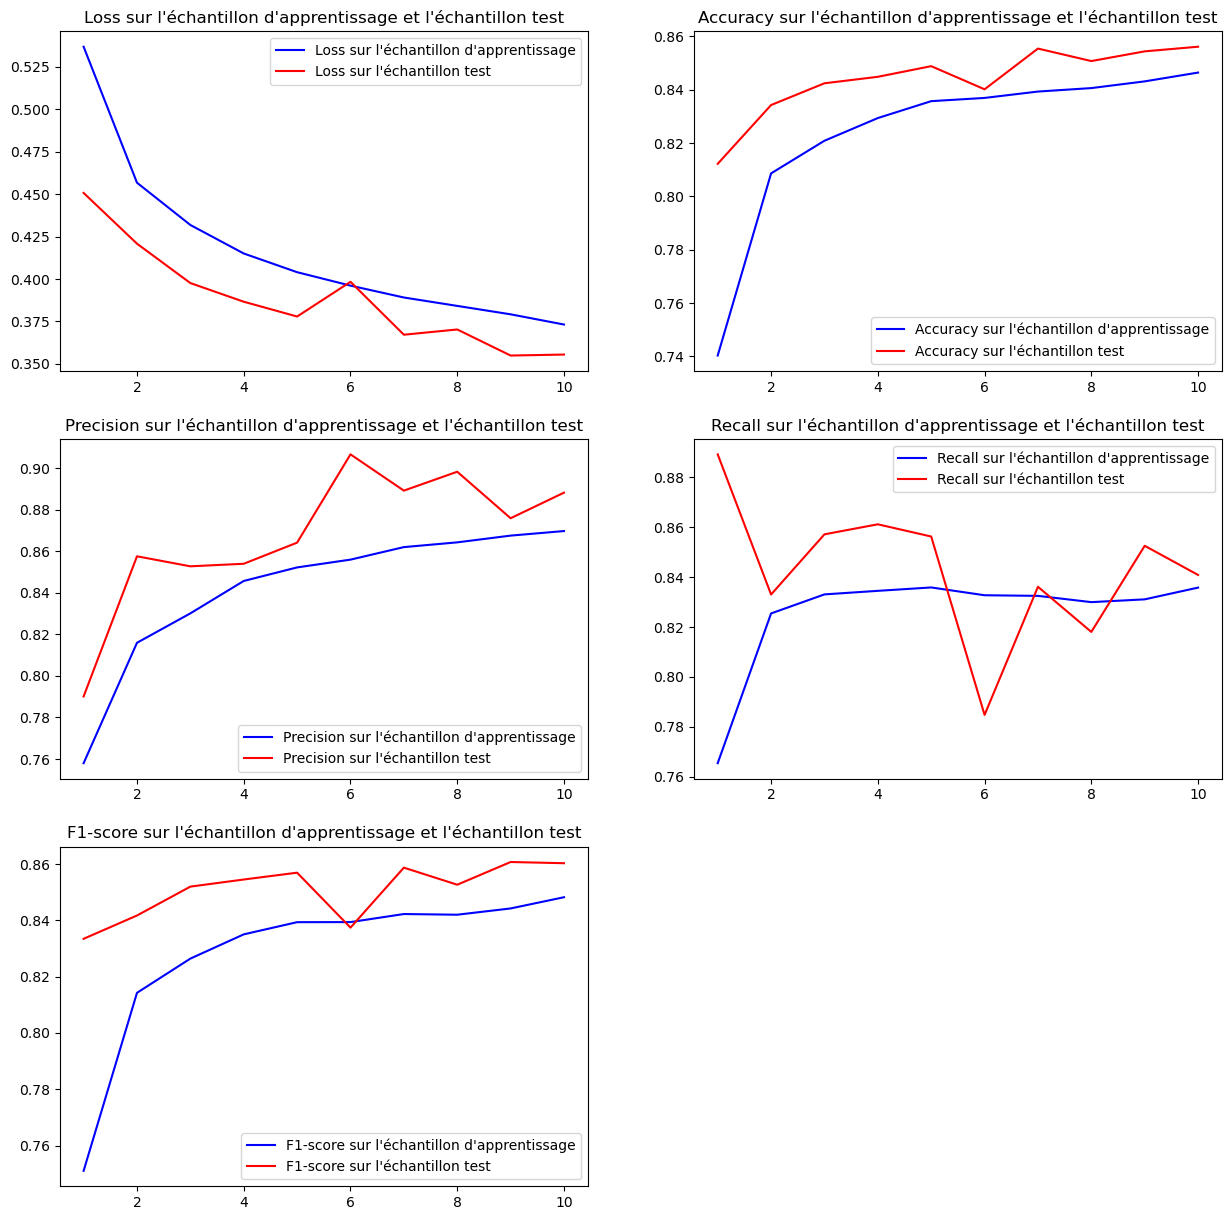

In [151]:
recall = history.history['recall_m']
val_recall = history.history['val_recall_m']

accuracy = history.history['Accuracy']
val_accuracy = history.history['val_Accuracy']

precision = history.history['precision_m']
val_precision = history.history['val_precision_m']

f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(recall) + 1)

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].plot(epochs, loss, 'b', label="Loss sur l'échantillon d'apprentissage")
axs[0, 0].plot(epochs, val_loss, 'b', label="Loss sur l'échantillon test", color="red")
axs[0, 0].set_title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 0].legend()

axs[0, 1].plot(epochs, accuracy, 'b', label="Accuracy sur l'échantillon d'apprentissage")
axs[0, 1].plot(epochs, val_accuracy, 'b', label="Accuracy sur l'échantillon test", color="red")
axs[0, 1].set_title("Accuracy sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 1].legend()

axs[1, 0].plot(epochs, precision, 'b', label="Precision sur l'échantillon d'apprentissage")
axs[1, 0].plot(epochs, val_precision, 'b', label="Precision sur l'échantillon test", color="red")
axs[1, 0].set_title("Precision sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 0].legend()

axs[1, 1].plot(epochs, recall, 'b', label="Recall sur l'échantillon d'apprentissage")
axs[1, 1].plot(epochs, val_recall, 'b', label="Recall sur l'échantillon test", color="red")
axs[1, 1].set_title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 1].legend()

axs[2, 0].plot(epochs, f1, 'b', label="F1-score sur l'échantillon d'apprentissage")
axs[2, 0].plot(epochs, val_f1, 'b', label="F1-score sur l'échantillon test", color="red")
axs[2, 0].set_title("F1-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 0].legend()

fig.delaxes(axs[2,1]) # The indexing is zero-based here


In [152]:
train_loss, train_accuracy, train_recall, train_precision, train_f1score = model_init.evaluate(
    X_train_permute.numpy(), Y_train.numpy(), verbose=0)
print("Loss sur l'échantillon train: {}".format(round(train_loss, 3)))
print("Accuracy sur l'échantillon train: {}".format(round(train_accuracy, 3)))
print("Recall sur l'échantillon train: {}".format(round(train_recall, 3)))
print("Precision sur l'échantillon train: {}".format(round(train_precision, 3)))
print("F1-score sur l'échantillon train: {}".format(round(train_f1score, 3)))

loss, accuracy, recall, precision, f1score = model_init.evaluate(
    X_test_permute.numpy(), Y_test.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(round(loss, 3)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy, 3)))
print("Recall sur l'échantillon test: {}".format(round(recall, 3)))
print("Precision sur l'échantillon test: {}".format(round(precision, 3)))
print("F1-score sur l'échantillon test: {}".format(round(f1score, 3)))

prob_predict = model_init.predict(X_test_permute.numpy())
y_pred = (np.squeeze(prob_predict) > 0.5).astype("int32")

unique, counts = np.unique(y_pred, return_counts=True)
res = dict(zip(unique, counts))
print("Nombre d'images prédites avec panneaux: {}".format(res[1]))
print("Nombre d'images prédites sans panneau: {}".format(res[0]))

Loss sur l'échantillon train: 0.347
Accuracy sur l'échantillon train: 0.861
Recall sur l'échantillon train: 0.837
Precision sur l'échantillon train: 0.894
F1-score sur l'échantillon train: 0.861
Loss sur l'échantillon test: 0.355
Accuracy sur l'échantillon test: 0.856
Recall sur l'échantillon test: 0.841
Precision sur l'échantillon test: 0.888
F1-score sur l'échantillon test: 0.86
181/181 [==============================] - 0s 2ms/step
Nombre d'images prédites avec panneaux: 2954
Nombre d'images prédites sans panneau: 2808


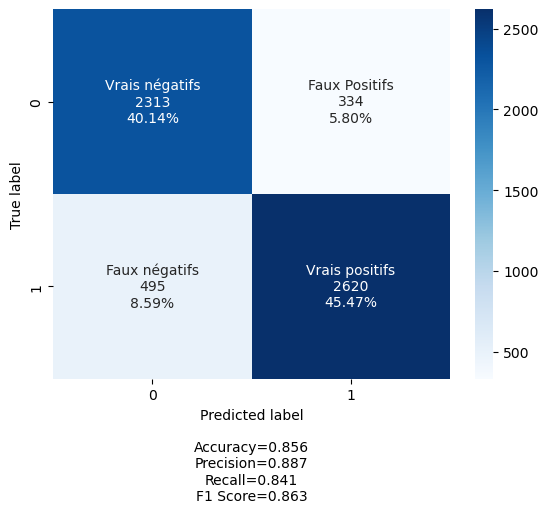

In [153]:
r = confusion_matrix(Y_test, y_pred)

labels = ["Vrais négatifs", "Faux Positifs", "Faux négatifs", "Vrais positifs"]
categories = ["0", "1"]
make_confusion_matrix(r,
                      group_names=labels,
                      categories=categories,
                      )


In [154]:
FPR, TPR, thresholds_keras = roc_curve(Y_test.numpy(), prob_predict)
AUC = auc(FPR, TPR)
print("AUC: {}".format(round(AUC, 2)))

AUC: 0.92


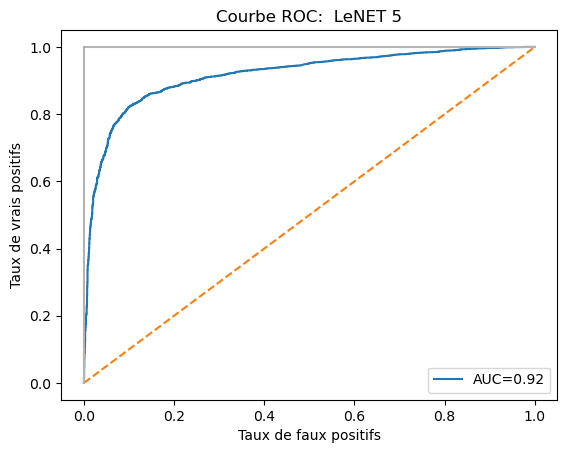

In [155]:
plt.title('Courbe ROC:  LeNET 5')
plt.plot(FPR, TPR, label="AUC="+str(round(AUC, 2)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.show()


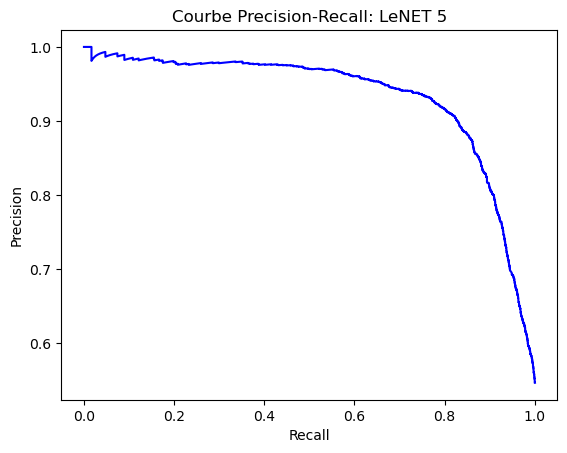

In [156]:
prec, rec, thresholds_keras = precision_recall_curve(Y_test.numpy(), prob_predict)

fig, ax = plt.subplots()
ax.plot(rec, prec, color='blue')

#add axis labels to plot
ax.set_title('Courbe Precision-Recall: LeNET 5')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

## Ajout de data augmentations

Comme les images sont de dimension relativement faible, on ne met pas de crop. De plus, on évite le colorjitter pour ne pas "détruire les images". Enfin,  comme les panneaux sont orientés au nord, on ne met pas de rotations aléatoires. Enfin, on normalise les données d'apprentissage et de test.

In [157]:
transformed_train_dataset = CustomImageDataset(path_train, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
    transforms.Resize(28),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Resize(28),
    transforms.ToTensor(),

]))

# On resize uniquement sur le test
transformed_test_dataset = CustomImageDataset(path_test, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                              transform=transforms.Compose([
                                                  transforms.Resize(28),
                                                  transforms.ToTensor(),
                                              ]))

train_dataloader = DataLoader(
    transformed_train_dataset, batch_size=23045, shuffle=True)
test_dataloader = DataLoader(
    transformed_test_dataset, batch_size=5762, shuffle=True)

mean_train, std_train = mean_std(train_dataloader)
print("Moyenne par channel: {}".format(mean_train.tolist()))
print("Ecart-type par channel: {}".format(std_train.tolist()))

mean_test, std_test = mean_std(test_dataloader)
print("Moyenne par channel: {}".format(mean_test.tolist()))
print("Ecart-type par channel: {}".format(std_test.tolist()))

normalized_train_dataset = CustomImageDataset(path_train, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
    transforms.Resize(28),
    transforms.RandomHorizontalFlip(
        p=0.5),
    transforms.RandomVerticalFlip(
        p=0.5),
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_train.tolist(),
                         std=std_train.tolist()),

]))


normalize_test_dataset = CustomImageDataset(path_test, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                            transform=transforms.Compose([
                                                transforms.Resize(28),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=mean_test.tolist(),
                                                                     std=std_test.tolist()),
                                            ]))
train_dataloader_augmente = DataLoader(
    normalized_train_dataset, batch_size=23045, shuffle=True)
test_dataloader_augmente = DataLoader(
    normalize_test_dataset, batch_size=5762, shuffle=True)




Moyenne par channel: [0.34925588965415955, 0.35663577914237976, 0.30716800689697266]
Ecart-type par channel: [0.16620372235774994, 0.14752432703971863, 0.14564631879329681]
Moyenne par channel: [0.349992573261261, 0.35766613483428955, 0.3081066906452179]
Ecart-type par channel: [0.16761955618858337, 0.14885342121124268, 0.1473139077425003]


## Apprentissage avec data augmentations

In [158]:
X_train_augmente, Y_train_augmente = next(iter(train_dataloader_augmente))
X_test_augmente, Y_test_augmente = next(iter(test_dataloader_augmente))

X_train_augmente_permute = X_train_augmente.permute(0, 2, 3, 1)
X_test_augmente_permute = X_test_augmente.permute(0, 2, 3, 1)

model_augmente = buildModel()

history_augmente = model_augmente.fit(x=X_train_augmente_permute.numpy(), y=Y_train_augmente.numpy(),
                                      validation_data=(
                                          X_test_augmente_permute.numpy(), Y_test_augmente.numpy()),
                                      batch_size=32,
                                      epochs=10)

Epoch 1/10
721/721 [==============================] - 6s 8ms/step - loss: 0.4997 - Accuracy: 0.7668 - recall_m: 0.8086 - precision_m: 0.7663 - f1_m: 0.7816 - val_loss: 0.4169 - val_Accuracy: 0.8232 - val_recall_m: 0.8376 - val_precision_m: 0.8358 - val_f1_m: 0.8328
Epoch 2/10
721/721 [==============================] - 6s 8ms/step - loss: 0.4228 - Accuracy: 0.8179 - recall_m: 0.8357 - precision_m: 0.8252 - f1_m: 0.8257 - val_loss: 0.3825 - val_Accuracy: 0.8417 - val_recall_m: 0.8693 - val_precision_m: 0.8419 - val_f1_m: 0.8522
Epoch 3/10
721/721 [==============================] - 6s 8ms/step - loss: 0.3974 - Accuracy: 0.8303 - recall_m: 0.8390 - precision_m: 0.8397 - f1_m: 0.8350 - val_loss: 0.3934 - val_Accuracy: 0.8301 - val_recall_m: 0.8830 - val_precision_m: 0.8150 - val_f1_m: 0.8438
Epoch 4/10
721/721 [==============================] - 6s 8ms/step - loss: 0.3907 - Accuracy: 0.8334 - recall_m: 0.8394 - precision_m: 0.8465 - f1_m: 0.8381 - val_loss: 0.3676 - val_Accuracy: 0.8410 - va

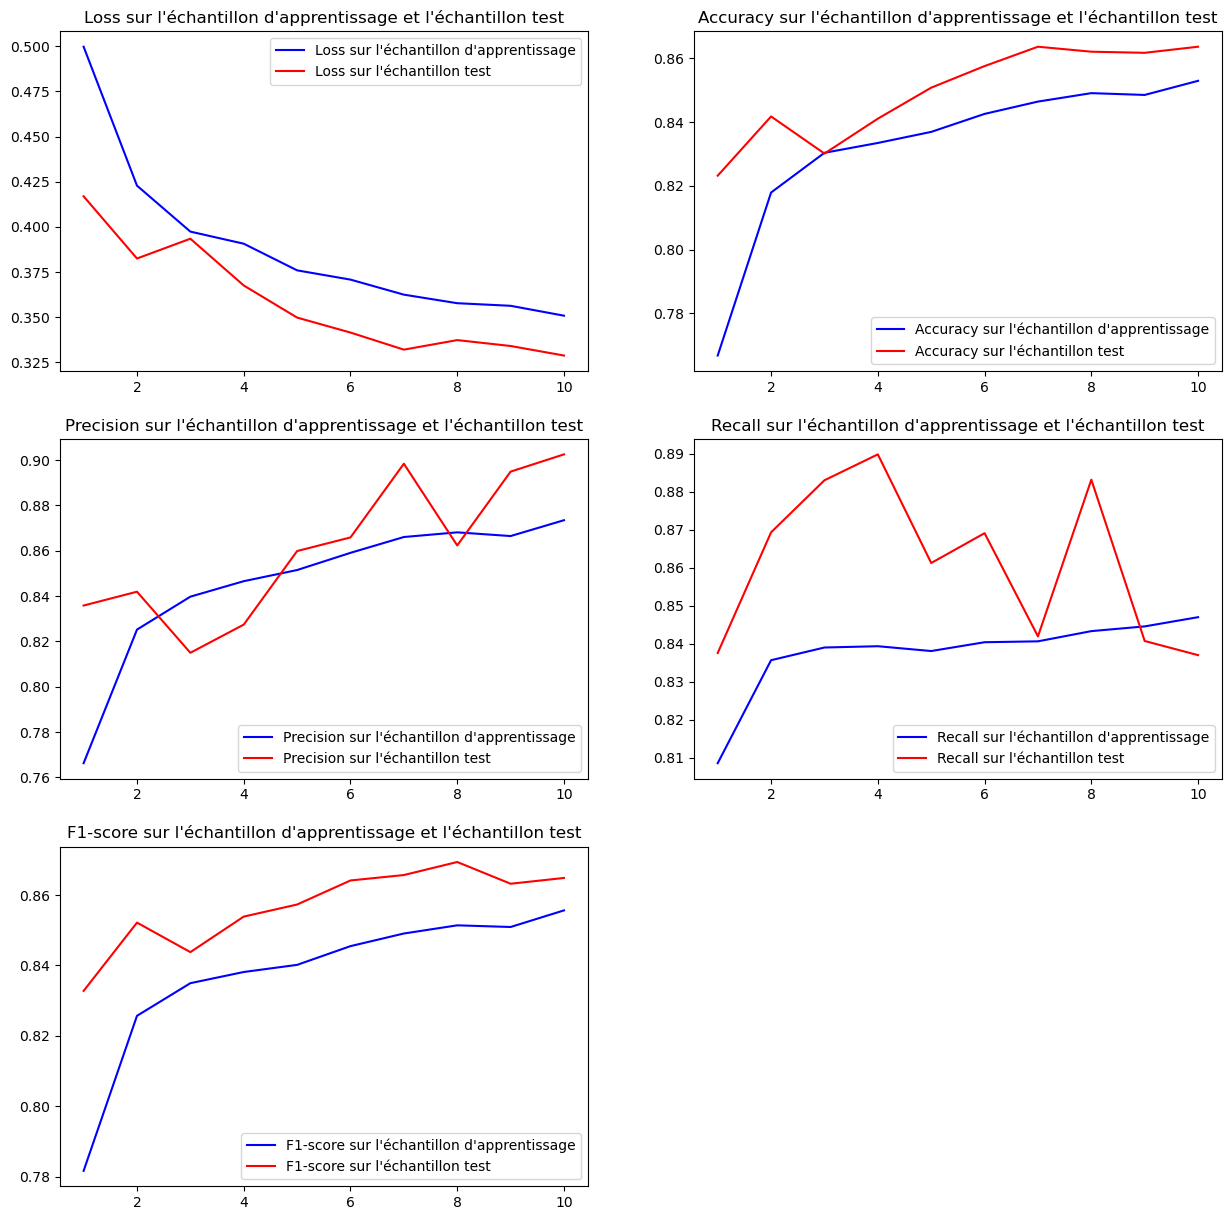

In [159]:
recall_augmente = history_augmente.history['recall_m']
val_recall_augmente = history_augmente.history['val_recall_m']

accuracy_augmente = history_augmente.history['Accuracy']
val_accuracy_augmente = history_augmente.history['val_Accuracy']

precision_augmente = history_augmente.history['precision_m']
val_precision_augmente = history_augmente.history['val_precision_m']

f1_augmente = history_augmente.history['f1_m']
val_f1_augmente = history_augmente.history['val_f1_m']

loss_augmente = history_augmente.history['loss']
val_loss_augmente = history_augmente.history['val_loss']

epochs_augmente = range(1, len(recall_augmente) + 1)

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].plot(epochs_augmente, loss_augmente, 'b', label="Loss sur l'échantillon d'apprentissage")
axs[0, 0].plot(epochs_augmente, val_loss_augmente, 'b', label="Loss sur l'échantillon test", color="red")
axs[0, 0].set_title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 0].legend()

axs[0, 1].plot(epochs_augmente, accuracy_augmente, 'b', label="Accuracy sur l'échantillon d'apprentissage")
axs[0, 1].plot(epochs_augmente, val_accuracy_augmente, 'b', label="Accuracy sur l'échantillon test", color="red")
axs[0, 1].set_title("Accuracy sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 1].legend()

axs[1, 0].plot(epochs_augmente, precision_augmente, 'b', label="Precision sur l'échantillon d'apprentissage")
axs[1, 0].plot(epochs_augmente, val_precision_augmente, 'b', label="Precision sur l'échantillon test", color="red")
axs[1, 0].set_title("Precision sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 0].legend()

axs[1, 1].plot(epochs_augmente, recall_augmente, 'b', label="Recall sur l'échantillon d'apprentissage")
axs[1, 1].plot(epochs_augmente, val_recall_augmente, 'b', label="Recall sur l'échantillon test", color="red")
axs[1, 1].set_title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 1].legend()

axs[2, 0].plot(epochs_augmente, f1_augmente, 'b', label="F1-score sur l'échantillon d'apprentissage")
axs[2, 0].plot(epochs_augmente, val_f1_augmente, 'b', label="F1-score sur l'échantillon test", color="red")
axs[2, 0].set_title("F1-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 0].legend()

fig.delaxes(axs[2,1]) # The indexing is zero-based here


In [160]:
loss_augmente_train, accuracy_augmente_train, recall_augmente_train, precision_augmente_train, f1score_augmente_train = model_augmente.evaluate(
    X_train_augmente_permute.numpy(), Y_train_augmente.numpy(), verbose=0)
print("Loss sur l'échantillon train: {}".format(round(loss_augmente_train, 3)))
print("Accuracy sur l'échantillon train: {}".format(round(accuracy_augmente_train, 3)))
print("Recall sur l'échantillon train: {}".format(round(recall_augmente_train, 3)))
print("Precision sur l'échantillon train: {}".format(round(precision_augmente_train, 3)))
print("F1-score sur l'échantillon train: {}".format(round(f1score_augmente_train, 3)))

loss_augmente, accuracy_augmente, recall_augmente, precision_augmente, f1score_augmente = model_augmente.evaluate(
    X_test_augmente_permute.numpy(), Y_test_augmente.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(round(loss_augmente, 3)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy_augmente, 3)))
print("Recall sur l'échantillon test: {}".format(round(recall_augmente, 3)))
print("Precision sur l'échantillon test: {}".format(round(precision_augmente, 3)))
print("F1-score sur l'échantillon test: {}".format(round(f1score_augmente, 3)))

prob_predict_augmente = model_augmente.predict(X_test_augmente_permute.numpy())
y_pred_augmente = (np.squeeze(prob_predict_augmente) > 0.5).astype("int32")

unique_augmente, counts_augmente = np.unique(
    y_pred_augmente, return_counts=True)
res_augmente = dict(zip(unique_augmente, counts_augmente))
print("Nombre d'images prédites avec panneaux: {}".format(res_augmente[1]))
print("Nombre d'images prédites sans panneau: {}".format(res_augmente[0]))



Loss sur l'échantillon train: 0.314
Accuracy sur l'échantillon train: 0.87
Recall sur l'échantillon train: 0.843
Precision sur l'échantillon train: 0.905
F1-score sur l'échantillon train: 0.87
Loss sur l'échantillon test: 0.329
Accuracy sur l'échantillon test: 0.864
Recall sur l'échantillon test: 0.837
Precision sur l'échantillon test: 0.902
F1-score sur l'échantillon test: 0.865
181/181 [==============================] - 1s 3ms/step
Nombre d'images prédites avec panneaux: 2887
Nombre d'images prédites sans panneau: 2875


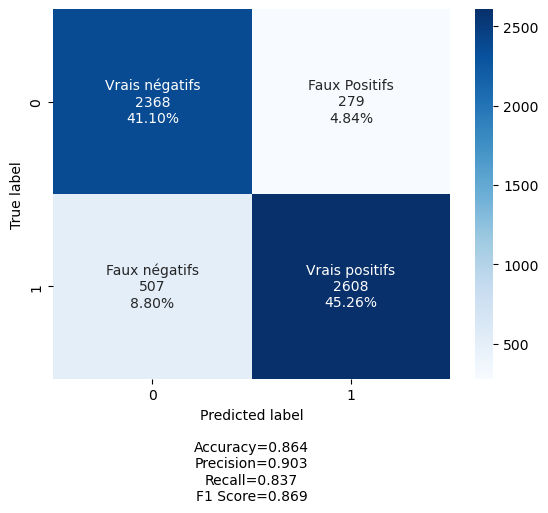

In [161]:
r = confusion_matrix(Y_test_augmente, y_pred_augmente)

labels = ["Vrais négatifs", "Faux Positifs", "Faux négatifs", "Vrais positifs"]
categories = ["0", "1"]
make_confusion_matrix(r,
                      group_names=labels,
                      categories=categories,
                      )


In [163]:
FPR_augmente, TPR_augmente, thresholds_keras_augmente = roc_curve(
    Y_test_augmente.numpy(), prob_predict_augmente)
AUC_augmente = auc(FPR_augmente, TPR_augmente)
print("AUC: {}".format(round(AUC_augmente, 2)))


AUC: 0.93


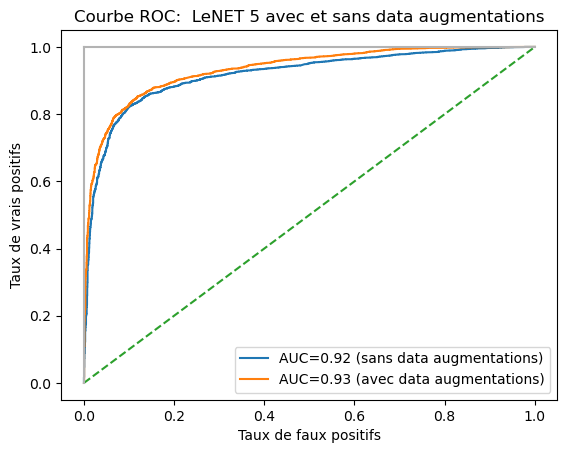

In [164]:
plt.title('Courbe ROC:  LeNET 5 avec et sans data augmentations')
plt.plot(FPR, TPR, label="AUC="+str(round(AUC, 2)) +
         " (sans data augmentations)")
plt.plot(FPR_augmente, TPR_augmente, label="AUC=" +
         str(round(AUC_augmente, 2))+" (avec data augmentations)")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.show()


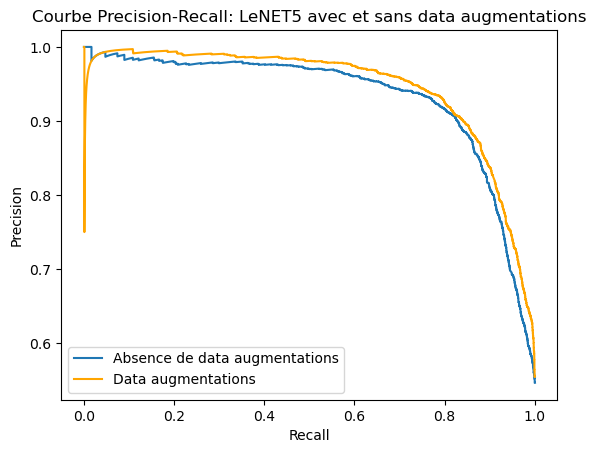

In [171]:
prec_augmente, rec_augmente, thresholds_keras = precision_recall_curve(Y_test_augmente.numpy(), prob_predict_augmente)

fig, ax = plt.subplots()
ax.plot(rec, prec, label="Absence de data augmentations")
ax.plot(rec_augmente, prec_augmente, color='orange', label="Data augmentations")

#add axis labels to plot
ax.set_title('Courbe Precision-Recall: LeNET5 avec et sans data augmentations')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.legend(loc=0)
plt.show()

# Hyperparamétrisation du modèle: random search

* n_iter: nombre de combinaisons d'hyperparamètres testées
* cv*n_iter = nombre d'itérations total

https://pyimagesearch.com/2021/05/31/hyperparameter-tuning-for-deep-learning-with-scikit-learn-keras-and-tensorflow/

https://towardsdatascience.com/hyper-parameter-tuning-with-randomised-grid-search-54f865d27926

In [37]:
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import RandomizedSearchCV

# learnRate = [1e-2, 1e-3, 1e-4]
# momentum = [0.9, 0.99]
# dropout1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout3 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout4 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# batchSize = [4, 8, 16, 32, 64, 128, 256]
# epochs = [10, 20, 30, 40, 50]

# grid = dict(
#     learnRate=learnRate,
#     momentum=momentum,
#     dropout1=dropout1,
#     dropout2=dropout2,
#     dropout3=dropout3,
#     dropout4=dropout4,
#     batch_size=batchSize,
#     epochs=epochs
# )

# model = KerasClassifier(build_fn=buildModel, verbose=1)
# #grid = GridSearchCV(estimator=model, param_grid=hyperMatrix)

# # n_iter: nombre de modèles entrainés
# searcher = RandomizedSearchCV(
#     estimator=model, cv=5, n_iter=60, param_distributions=grid, scoring='recall')
# searchResults = searcher.fit(
#     X_train_augmente_permute.numpy(), Y_train_augmente.numpy())


Epoch 1/40
1153/1153 [==============================] - 9s 7ms/step - loss: 1.1712 - Accuracy: 0.5087 - recall_m: 0.5413 - precision_m: 0.5368 - f1_m: 0.5236
Epoch 2/40
1153/1153 [==============================] - 6s 5ms/step - loss: 1.2736 - Accuracy: 0.5100 - recall_m: 0.5442 - precision_m: 0.5392 - f1_m: 0.5266
Epoch 3/40
1153/1153 [==============================] - 8s 7ms/step - loss: 1.3057 - Accuracy: 0.5036 - recall_m: 0.5371 - precision_m: 0.5310 - f1_m: 0.5199
Epoch 4/40
1153/1153 [==============================] - 6s 5ms/step - loss: 1.2746 - Accuracy: 0.5082 - recall_m: 0.5469 - precision_m: 0.5370 - f1_m: 0.5267
Epoch 5/40
1153/1153 [==============================] - 8s 7ms/step - loss: 1.3077 - Accuracy: 0.5056 - recall_m: 0.5416 - precision_m: 0.5345 - f1_m: 0.5220
Epoch 6/40
1153/1153 [==============================] - 6s 5ms/step - loss: 1.3346 - Accuracy: 0.5042 - recall_m: 0.5353 - precision_m: 0.5340 - f1_m: 0.5190
Epoch 7/40
1153/1153 [==============================

In [38]:
# # summarize grid search information
# bestScore = searchResults.best_score_
# bestParams = searchResults.best_params_
# print("[INFO] best score is {} using {}".format(round(bestScore, 3),
#                                                 bestParams))


[INFO] best score is 0.896 using {'momentum': 0.99, 'learnRate': 0.001, 'epochs': 20, 'dropout4': 0.1, 'dropout3': 0.7, 'dropout2': 0.7, 'dropout1': 0.6, 'batch_size': 32}


In [39]:
# searchResults.cv_results_["mean_test_score"]

array([0.6096977 , 0.65432337, 0.66908522, 0.87451248, 0.6831274 ,
       0.66342882, 0.89580364, 0.80827022, 0.56416038, 0.60200855])

# Résultats sur le modèle optimisé

In [172]:
best_model = buildModel(learnRate=0.001, dropout1=0.6, dropout2=0.7,
                        dropout3=0.7, dropout4=0.4, momentum=0.99)

history_best = best_model.fit(x=X_train_augmente_permute.numpy(), y=Y_train_augmente.numpy(),
                              validation_data=(
                                  X_test_augmente_permute.numpy(), Y_test_augmente.numpy()),
                              batch_size=32,
                              epochs=20)


Epoch 1/20
721/721 [==============================] - 7s 9ms/step - loss: 0.6539 - Accuracy: 0.6296 - recall_m: 0.7121 - precision_m: 0.6345 - f1_m: 0.6648 - val_loss: 0.6188 - val_Accuracy: 0.7393 - val_recall_m: 0.8959 - val_precision_m: 0.7054 - val_f1_m: 0.7840
Epoch 2/20
721/721 [==============================] - 6s 9ms/step - loss: 0.5557 - Accuracy: 0.7317 - recall_m: 0.7977 - precision_m: 0.7246 - f1_m: 0.7539 - val_loss: 0.5278 - val_Accuracy: 0.7824 - val_recall_m: 0.9081 - val_precision_m: 0.7456 - val_f1_m: 0.8142
Epoch 3/20
721/721 [==============================] - 6s 9ms/step - loss: 0.5323 - Accuracy: 0.7537 - recall_m: 0.8073 - precision_m: 0.7484 - f1_m: 0.7708 - val_loss: 0.4772 - val_Accuracy: 0.7985 - val_recall_m: 0.8812 - val_precision_m: 0.7772 - val_f1_m: 0.8211
Epoch 4/20
721/721 [==============================] - 6s 8ms/step - loss: 0.5119 - Accuracy: 0.7687 - recall_m: 0.8148 - precision_m: 0.7653 - f1_m: 0.7841 - val_loss: 0.4460 - val_Accuracy: 0.8146 - va

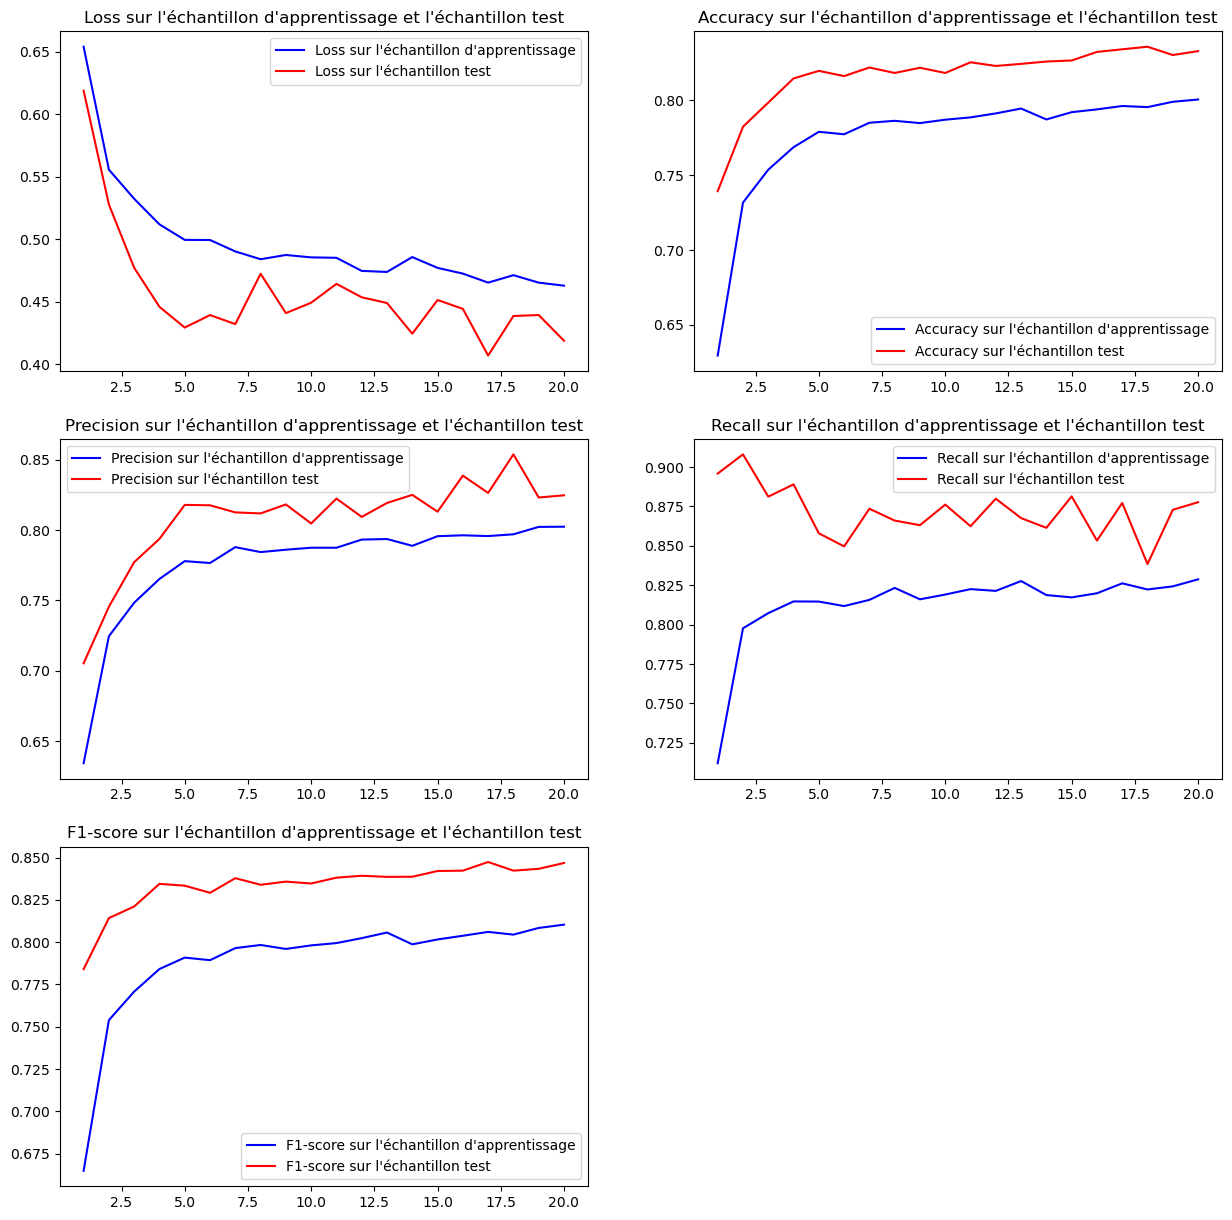

In [173]:
recall_best = history_best.history['recall_m']
val_recall_best = history_best.history['val_recall_m']

accuracy_best = history_best.history['Accuracy']
val_accuracy_best = history_best.history['val_Accuracy']

precision_best = history_best.history['precision_m']
val_precision_best = history_best.history['val_precision_m']

f1_best = history_best.history['f1_m']
val_f1_best = history_best.history['val_f1_m']

loss_best = history_best.history['loss']
val_loss_best = history_best.history['val_loss']

epochs_best = range(1, len(recall_best) + 1)

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].plot(epochs_best, loss_best, 'b', label="Loss sur l'échantillon d'apprentissage")
axs[0, 0].plot(epochs_best, val_loss_best, 'b', label="Loss sur l'échantillon test", color="red")
axs[0, 0].set_title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 0].legend()

axs[0, 1].plot(epochs_best, accuracy_best, 'b', label="Accuracy sur l'échantillon d'apprentissage")
axs[0, 1].plot(epochs_best, val_accuracy_best, 'b', label="Accuracy sur l'échantillon test", color="red")
axs[0, 1].set_title("Accuracy sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 1].legend()

axs[1, 0].plot(epochs_best, precision_best, 'b', label="Precision sur l'échantillon d'apprentissage")
axs[1, 0].plot(epochs_best, val_precision_best, 'b', label="Precision sur l'échantillon test", color="red")
axs[1, 0].set_title("Precision sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 0].legend()

axs[1, 1].plot(epochs_best, recall_best, 'b', label="Recall sur l'échantillon d'apprentissage")
axs[1, 1].plot(epochs_best, val_recall_best, 'b', label="Recall sur l'échantillon test", color="red")
axs[1, 1].set_title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 1].legend()

axs[2, 0].plot(epochs_best, f1_best, 'b', label="F1-score sur l'échantillon d'apprentissage")
axs[2, 0].plot(epochs_best, val_f1_best, 'b', label="F1-score sur l'échantillon test", color="red")
axs[2, 0].set_title("F1-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 0].legend()

fig.delaxes(axs[2,1]) # The indexing is zero-based here


In [174]:
loss_best_train, accuracy_best_train, recall_best_train, precision_best_train, f1score_best_train = best_model.evaluate(
    X_train_augmente_permute.numpy(), Y_train_augmente.numpy(), verbose=0)
print("Loss sur l'échantillon train: {}".format(round(loss_best_train, 3)))
print("Accuracy sur l'échantillon train: {}".format(round(accuracy_best_train, 3)))
print("Recall sur l'échantillon train: {}".format(round(recall_best_train, 3)))
print("Precision sur l'échantillon train: {}".format(round(precision_best_train, 3)))
print("F1-score sur l'échantillon train: {}".format(round(f1score_best_train, 3)))

loss_best, accuracy_best, recall_best, precision_best, f1score_best = best_model.evaluate(
    X_test_augmente_permute.numpy(), Y_test_augmente.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(round(loss_best, 3)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy_best, 3)))
print("Recall sur l'échantillon test: {}".format(round(recall_best, 3)))
print("Precision sur l'échantillon test: {}".format(round(precision_best, 3)))
print("F1-score sur l'échantillon test: {}".format(round(f1score_best, 3)))

best_predict = best_model.predict(X_test_augmente_permute.numpy())
best_y_pred = (np.squeeze(best_predict) > 0.5).astype("int32")

uni_best, compteur_best = np.unique(best_y_pred, return_counts=True)
res_best = dict(zip(uni_best, compteur_best))
print("Nombre d'images prédites avec panneaux: {}".format(res_best[1]))
print("Nombre d'images prédites sans panneau: {}".format(res_best[0]))

Loss sur l'échantillon train: 0.425
Accuracy sur l'échantillon train: 0.831
Recall sur l'échantillon train: 0.872
Precision sur l'échantillon train: 0.82
F1-score sur l'échantillon train: 0.841
Loss sur l'échantillon test: 0.419
Accuracy sur l'échantillon test: 0.833
Recall sur l'échantillon test: 0.878
Precision sur l'échantillon test: 0.825
F1-score sur l'échantillon test: 0.847
181/181 [==============================] - 0s 2ms/step
Nombre d'images prédites avec panneaux: 3310
Nombre d'images prédites sans panneau: 2452


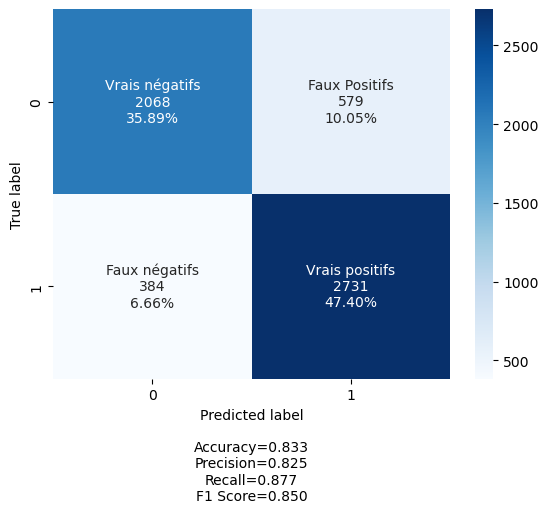

In [175]:
r = confusion_matrix(Y_test_augmente, best_y_pred)

labels = ["Vrais négatifs", "Faux Positifs", "Faux négatifs", "Vrais positifs"]
categories = ["0", "1"]
make_confusion_matrix(r,
                      group_names=labels,
                      categories=categories,
                      )


In [176]:
FPR_best, TPR_best, thresholds_keras_best = roc_curve(
    Y_test_augmente.numpy(), best_predict)
AUC_best = auc(FPR_best, TPR_best)
print("AUC: {}".format(round(AUC_best, 2)))


AUC: 0.9


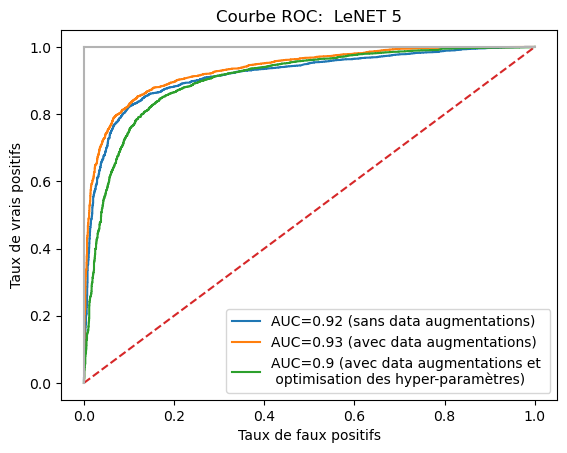

In [177]:
plt.title('Courbe ROC:  LeNET 5')
plt.plot(FPR, TPR, label="AUC="+str(round(AUC, 2)) +
         " (sans data augmentations)")
plt.plot(FPR_augmente, TPR_augmente, label="AUC=" +
         str(round(AUC_augmente, 2))+" (avec data augmentations)")
plt.plot(FPR_best, TPR_best, label="AUC="+str(round(AUC_best, 2)) +
         " (avec data augmentations et \n optimisation des hyper-paramètres)")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.show()


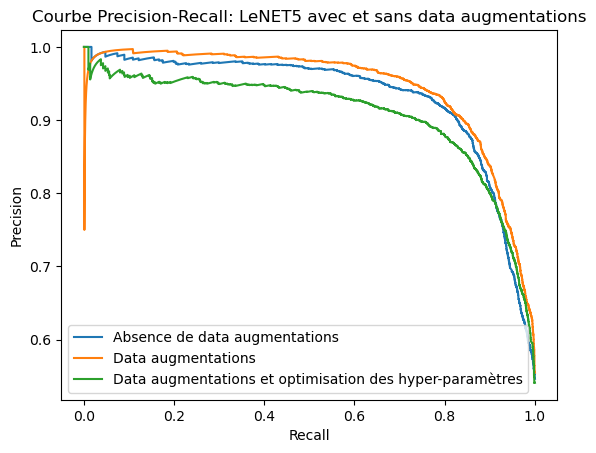

In [178]:
prec_best, rec_best, thresholds_keras_best = precision_recall_curve(Y_test_augmente.numpy(), best_predict)

fig, ax = plt.subplots()
ax.plot(rec, prec, label="Absence de data augmentations")
ax.plot(rec_augmente, prec_augmente, label="Data augmentations")
ax.plot(rec_best, prec_best, label="Data augmentations et optimisation des hyper-paramètres")

#add axis labels to plot
ax.set_title('Courbe Precision-Recall: LeNET5 avec et sans data augmentations')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.legend(loc=0)
plt.show()